## Wokflow for Utah rock glacier coverage
Matt Olson - 02/2025

In [1]:
# import libraries and functions
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
from shapely.geometry import Point
from matplotlib import pyplot as plt

import ee
import geemap 

# import json
from datetime import datetime
import os

In [2]:
# autheniticate
ee.Authenticate()
ee.Initialize()

In [188]:
## FUNCTIONS 1 - ndsi and pixel counts

# apply threshold to ndsi values (0.2 and 0.4 options)
def ls_threshold02(image):
    return image.gte(0.2).selfMask() # greater than or equal to (gte)
def ls_threshold04(image):
    return image.gte(0.4).selfMask()

# scale values, clip, and run NDSI
def ls8_ndsi_clip(image):
    image = image.multiply(0.0000275).add(-0.2).clip(rg) # scale and clip
    index = image.normalizedDifference(['SR_B3','SR_B6']).rename('ndsi');
    return image.addBands(index)
def ls8_scale_clip(image):
    image = image.multiply(0.0000275).add(-0.2).clip(rg) # scale and clip
    return image
def ls5_ndsi_clip(image):
    image = image.multiply(0.0000275).add(-0.2).clip(rg) # scale and clip
    index = image.normalizedDifference(['B2','B5']).rename('ndsi');
    return image.addBands(index)
def ls5_scale_clip(image):
    image = image.multiply(0.0000275).add(-0.2).clip(rg) # scale and clip
    return image

# Function to count pixels in an image
def count_pixels(image):
    total_pixels = image.select(0).reduceRegion(
        reducer=ee.Reducer.count(),
        geometry=rg,
        scale=30,  # Adjust scale as needed (Sentinel -20; Landsat -30
        maxPixels=1e13
    ).get(image.bandNames().get(0))
    return ee.Feature(None, {'image_id': image.id(), 'pixel_count': total_pixels})

# Function to extract date from image name and convert to datetime
def extract_date(image_name):
    date_str = image_name[-8:]
    date_obj = datetime.strptime(date_str, '%Y%m%d')
    return date_obj


def closest_to_oct15(group):
    oct15 = pd.Timestamp(f'{group["year"].iloc[0]}-10-15')  # October 15th of the year
    # Find the closest date before or after October 15
    before_oct15 = group[group['date'] <= oct15].iloc[-1]  # Closest before or on Oct 15
    after_oct15 = group[group['date'] >= oct15].iloc[0]  # Closest after or on Oct 15
    # Return the one with the minimum area_km2
    return before_oct15 if before_oct15['area_km2'] <= after_oct15['area_km2'] else after_oct15

In [97]:
# FUNCTIONS 2 - cloud masking
def fmask(image):
    # see https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC09_C02_T1_L2
    # Bit 0 - Fill
    # Bit 1 - Dilated Cloud
    # Bit 2 - Cirrus
    # Bit 3 - Cloud
    # Bit 4 - Cloud Shadow
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)

    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)

    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True).updateMask(qaMask)

# Function to extract the cloud mask from a Landsat 8 image
def get_cloud_mask(image):
    # Get the QA band (cloud mask band)
    cloud_mask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).neq(0)

    # Apply the cloud mask to the image (so that clouds are masked out)
    return image.updateMask(cloud_mask).set('cloud_mask', cloud_mask)


# Function to calculate cloud coverage within the region of interest (rg)
def calculate_cloud_coverage(image, roi):
    # Get the cloud mask for the image
    cloud_mask = image.get('cloud_mask')
    
    # Calculate the area of each pixel
    pixel_area = ee.Image.pixelArea()
    
    # Mask the pixel area by the cloud mask
    cloud_area = pixel_area.updateMask(cloud_mask).clip(roi)
    
    # Calculate the total area of the region of interest (based on number of pixels in roi)
    total_area = pixel_area.clip(roi).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=roi,
        scale=30,
        maxPixels=1e8
    ).get('area')
    
    # Calculate the cloud area within the region of interest
    cloud_area_sum = cloud_area.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=roi,
        scale=30,
        maxPixels=1e8
    ).get('area')
    
    # Calculate the percentage of cloud coverage
    cloud_coverage = ee.Number(cloud_area_sum).divide(total_area).multiply(100)
    
    # Set the cloud coverage as a property
    return image.set('cloud_coverage', cloud_coverage)

# Function to convert the image collection into a DataFrame with image names and cloud coverage
def collection_to_dataframe(image_collection, roi):
    # Function to extract the cloud coverage for each image in the collection
    def extract_cloud_coverage(image):
        # Calculate cloud coverage for each image
        image_with_coverage = calculate_cloud_coverage(image, roi)
        
        # Return image as a feature with cloud coverage
        return ee.Feature(None, {
            'image_name': image.id(),
            'cloud_coverage': image_with_coverage.get('cloud_coverage')
        })
    
    # Apply the function to each image in the collection
    features = image_collection.map(extract_cloud_coverage)
    
    # Convert the FeatureCollection to a pandas DataFrame
    feature_list = features.getInfo()
    cloud_coverage_list = [{'image_name': feature['properties']['image_name'],
                            'cloud_coverage': feature['properties']['cloud_coverage']}
                           for feature in feature_list['features']]
    
    # Convert the list to a DataFrame
    df = pd.DataFrame(cloud_coverage_list)
    
    return df

In [3]:
# read in boundary
rg = geemap.shp_to_ee('shp/timp-rg/timp.shp')

## Landsat imagery

Landsat products: https://developers.google.com/earth-engine/datasets/catalog/landsat
Landsat 8: https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2


Initial filter includes:
* dates
* spatial
* cloud
* month range

*Images cover...*

In [132]:
# filter collection 
start_date = '2013-08-01'; end_date = '2024-11-30' 
# 1984

# landsat 8
ls8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterDate(start_date, end_date) \
    .filterBounds(rg) \
    .filter(ee.Filter.lt('CLOUD_COVER', 10)) \
    .filter(ee.Filter.calendarRange(8, 11, 'month'))  

# landsat 7
ls7 = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2") \
    .filterDate('1999-08-01', '2002-10-31') \
    .filterBounds(rg) \
    .filter(ee.Filter.lt('CLOUD_COVER', 10)) \
    .filter(ee.Filter.calendarRange(8, 10, 'month'))  

# landsat 5
ls5 = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2") \
    .filterDate('1983-08-01', '2015-10-31') \
    .filterBounds(rg) \
    .filter(ee.Filter.lt('CLOUD_COVER', 10)) \
    .filter(ee.Filter.calendarRange(8, 10, 'month'))  

# # landsat 7
# ls7 = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2")
# l7_filtered = s2.filterDate(start_date, end_date).filterBounds(rg) \
#                         .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
#                         .filter(ee.Filter.calendarRange(8, 10, 'month'))
# # landsat 6
# ls5 = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")
# l5_filtered = s2.filterDate(start_date, end_date).filterBounds(rg) \
#                         .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
#                         .filter(ee.Filter.calendarRange(8, 10, 'month'))

In [133]:
ls8 # 32 elements (2013-2024)
# ls7 # 8 elements (1999-2002)
# ls5 # 80 elements (1983-2015)

In [8]:
## Filter for total scene coverage?
# implimented later...

## Cloud masking

Cloud masking is agressive over snow covered, and partially snow covered, areas. Recommended to not directly use the masking, rather observe percentages in post-processing. This section creates a cloud masked dataset and adds a property to show where clouds have been classified with the *QA_PIXEL* layer.

A dataframe is created to show cloud percentage over specieid area (polygon) of interest (rg).

Further work could be done with the CFMASK algorithm.

In [134]:
# create collection with all clouds, shadows, etc. masked
ls8_fmask = ls8.map(fmask)

In [135]:
ls8_fmask

In [136]:
# ls8.first().updateMask(ls8_fmask).multiply(0.0000275).add(-0.2)

In [137]:
# observe and compare cloud mask
Map = geemap.Map()
Map.centerObject(rg, 14)
# Add the first image to the map with the cloud mask applied
image = ls8.first()
cloud_mask = ls8_fmask.first()

Map.addLayer(image, {'min': 200, 'max': 40000, 'bands': ['SR_B4', 'SR_B3', 'SR_B2']}, 'RGB')
Map.addLayer(cloud_mask, {'min': 0, 'max': 0.55, 'bands': ['SR_B4', 'SR_B3', 'SR_B2']}, 'CFMASK')
Map

Map(center=[40.389565168100816, -111.64058143725468], controls=(WidgetControl(options=['position', 'transparen…

In [138]:
# Apply the cloud mask function to the collection
ls8_cloud = ls8.map(get_cloud_mask)

# convert the filtered collection to a dataframe with image names and cloud coverage
df_cloud = collection_to_dataframe(ls8_cloud, rg)

# dataframe
df_cloud.head(6)


image_name  cloud_coverage
0  LC08_038032_20140815      100.000000
1  LC08_038032_20140831      100.000000
2  LC08_038032_20141002       43.016342
3  LC08_038032_20141018       41.851126
4  LC08_038032_20150818        2.528518
5  LC08_038032_20150919      100.000000

In [139]:
ls8_cloud

In [140]:
# observe and compare cloud mask
Map = geemap.Map()
Map.centerObject(rg, 12)

# images
image = ls8.first()
cloud_mask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).neq(0)
cloud_mask = cloud_mask.updateMask(cloud_mask)

# map layers
Map.addLayer(image.multiply(0.0000275).add(-0.2), {'min': 0, 'max': 0.45, 'bands': ['SR_B4', 'SR_B3', 'SR_B2']}, 'RGB')
Map.addLayer(cloud_mask, {'min': 0, 'max': 1,'palette': ['000000', 'blue']}, 'Cloud Mask')

Map

Map(center=[40.389565168100816, -111.64058143725468], controls=(WidgetControl(options=['position', 'transparen…

In [141]:
# show other scenes
Map = geemap.Map()

# first 10 scenes only
scene_number = 4

# get date
image_id = ee.Image(ls8.toList(10).get(scene_number)).get('system:index').getInfo()
date_part = image_id[-8:]
date_obj = datetime.strptime(date_part, '%Y%m%d')
formatted_date = date_obj.strftime('%m-%d-%Y')
print("Scene aquisition " + formatted_date)

# select images
image = ee.Image(ls8.toList(10).get(scene_number))
image_cloudless = ee.Image(ls8_fmask.toList(10).get(scene_number))
cloud_mask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).neq(0)

rg_poly_params = {'color': '000000', 'pointSize': 3,'width': 2,'lineType': 'solid','fillColor': '00000000'}
Map.centerObject(rg, 14)
# add original image, clouds (blue), rglacier outline (black)
Map.addLayer(image.multiply(0.0000275).add(-0.2), {'min': 0, 'max': 0.45, 'bands': ['SR_B4', 'SR_B3', 'SR_B2']}, \
             'RGB '  + formatted_date)
Map.addLayer(image_cloudless, {'min': 0, 'max': 0.45, 'bands': ['SR_B4', 'SR_B3', 'SR_B2']}, \
             'RGB cloud mask')
Map.addLayer(cloud_mask.updateMask(cloud_mask), \
             {'min': 0, 'max': 1, 'palette': ['000000', 'blue']}, 'Clouds')
Map.addLayer(rg.style(**rg_poly_params), {}, "Rock glacier outline")

Map

Scene aquisition 08-18-2015


Map(center=[40.389565168100816, -111.64058143725468], controls=(WidgetControl(options=['position', 'transparen…

Cloud coverage should not be used to mask outimage but can be applied later to correct for situations where the entire outline is obscured by a small cloud *since an initial cloud filter is already applied to the image*.

**Overall**, the fmask algorithm is aggressive in mountainous terrain

## NDSI

For accurate index calculation, surface reflectance product must be scaled, prior to calculating the NDSI. Landsat [NDSI](https://www.usgs.gov/landsat-missions/normalized-difference-snow-index) uses green with SWIR with the standard index method of $\frac{G - SWIR1}{G + SWIR1}$.

Landsat 8-9 use:
$\frac{B3 - B6}{B3 + B6}$ 

Landsat 4-7 use:
$\frac{B2 - B5}{B2 + B5}$ 

THe standard threshold of **0.4** is applied rather than 0.4+++ to capture late season snow on the rock glacier (should find sources to support this).

Snow pixels at or above threshold value are counted and converted to area based on the input rock glacier polygon (rg).

In [142]:
# NDSI w/ THRESHOLD
# scale and clip imagery prior to ndsi calculation
ls8_ndsi = ls8.map(ls8_ndsi_clip)
ls8_clip = ls8.map(ls8_scale_clip)

# apply threshold of 0.2
ls8_thresh = ls8_ndsi.map(ls_threshold04) # s2_threshold02 also exists

In [252]:
# original
def count_pixels(image):
    total_pixels = image.select(0).reduceRegion(
        reducer=ee.Reducer.count(),
        geometry=rg,
        scale=30,  # Adjust scale as needed (Sentinel -20; Landsat -30
        maxPixels=1e13
    ).get(image.bandNames().get(0))
    return ee.Feature(None, {'image_id': image.id(), 'pixel_count': total_pixels})

# new
def count_pixels(image):
    total_pixels = image.select(['ndsi']).updateMask(image.select(['ndsi'])).reduceRegion(
        reducer=ee.Reducer.count(),
        geometry=rg,
        scale=30,  # Adjust scale as needed (Sentinel -20; Landsat -30
        maxPixels=1e13
    ).get(image.bandNames().get(19))
    return ee.Feature(None, {'image_id': image.id(), 'pixel_count': total_pixels})

In [250]:
ls8_thresh.map(count_pixels)

In [253]:
# PIXEL COUNT DATAFRAME
# Map over the image collection
pix_count = ls8_thresh.map(count_pixels)
pix_count_total = ls8_ndsi.map(count_pixels)

# Convert to FeatureCollection and then pandas DataFrame
pix_count_collection = ee.FeatureCollection(pix_count)
df1 = geemap.ee_to_df(pix_count_collection)
pix_count_total_collection = ee.FeatureCollection(pix_count_total)
df2 = geemap.ee_to_df(pix_count_total_collection)
df2.rename(columns={'pixel_count': 'total_count'}, inplace=True)

# Display as table
# df_area = pd.concat([df, df2], axis=1) # df_area = df.join(df2)
# df_area = pd.merge(df1, df2, on=['image_id','image_id'])
df_area = pd.merge(df1, df2, left_index=True, right_index=True)
df_area.drop('image_id_y', axis=1, inplace=True)

# percent of coverage
max_pix = df_area['total_count'].max()
df_area['scene_perc'] = df_area['total_count'] / max_pix
df_area['snow_perc'] = df_area['pixel_count'] / max_pix
print(f"original dataset dimension: {df_area.shape}")

# create subset
scenep_cov = 1
dfa_sub = df_area[df_area['scene_perc'] >= scenep_cov]
# dfa_sub.drop(['total_count','scene_cover'], axis=1, inplace=True)
dfa_sub = dfa_sub.drop(['total_count','scene_perc'], axis=1)
print(f"scenes with full polygon coverage: {dfa_sub.shape[0]}")
print(f"removing {df_area.shape[0] - dfa_sub.shape[0]} scenes due to coverage less than {scenep_cov*100}%")


dfa_sub.head(5)

original dataset dimension: (43, 5)
scenes with full polygon coverage: 11
removing 32 scenes due to coverage less than 100%


image_id_x  pixel_count  snow_perc
2   LC08_038032_20141002          149   1.000000
9   LC08_038032_20161007          149   1.000000
10  LC08_038032_20161108          148   0.993289
12  LC08_038032_20171010          149   1.000000
19  LC08_038032_20190914          149   1.000000

In [247]:
df_rg.head(3)
# df2.head(3)
df_cloud.head(3)
# df_rg[df_rg['cloud_perc'] <= cloudp_thresh]

image_name  cloud_perc
0  LC08_038032_20140815  100.000000
1  LC08_038032_20140831  100.000000
2  LC08_038032_20141002   43.016342

In [254]:
# DATAFRAME MERGE - add dates, area, and cloud percentage to pixel count
df2 = dfa_sub

# Apply the function to the 'image_name' column
df2['date'] = df2['image_id_x'].apply(extract_date)
df2 = df2.drop('image_id_x', axis=1)

# Calculate the area in square meters
df2['area_m2'] = df2['pixel_count'] * 400  # 400 m^2 per pixel (20m x 20m)
df2['area_km2'] = df2['pixel_count'] * 400 / 1_000_000 # sq km

# Add a column for the day of the year
df2['day_of_year'] = df2['date'].dt.dayofyear

# merge with cloud dataset
df_cloud.rename(columns={'cloud_coverage':'cloud_perc'}, inplace=True)
df_rg = pd.merge(df2, df_cloud, left_index=True, right_index=True)
cloudp_thresh = 75
# df_rg = df_rg[df_rg['cloud_perc'] <= cloudp_thresh]
df_rg.drop('image_name', axis=1, inplace=True)
print(f"removing {dfa_sub.shape[0] - df_rg.shape[0]} scenes based on {cloudp_thresh}% cloud coverage")
print(f"final dataset dimension: {df_rg.shape}")

df_rg = df_rg.iloc[:,[2,5,0,1,3,4,6]]

df_rg.head(15)

removing 0 scenes based on 75% cloud coverage
final dataset dimension: (11, 7)


date  day_of_year  pixel_count  snow_perc  area_m2  area_km2  \
2  2014-10-02          275          149   1.000000    59600    0.0596   
9  2016-10-07          281          149   1.000000    59600    0.0596   
10 2016-11-08          313          148   0.993289    59200    0.0592   
12 2017-10-10          283          149   1.000000    59600    0.0596   
19 2019-09-14          257          149   1.000000    59600    0.0596   
20 2019-09-30          273          101   0.677852    40400    0.0404   
22 2019-11-01          305          149   1.000000    59600    0.0596   
23 2019-11-17          321          124   0.832215    49600    0.0496   
28 2021-09-19          262            0   0.000000        0    0.0000   
29 2021-10-21          294          149   1.000000    59600    0.0596   
37 2023-10-27          300          102   0.684564    40800    0.0408   

    cloud_perc  
2    43.016342  
9   100.000000  
10   53.845663  
12   33.311136  
19   74.528846  
20  100.000000  
22   56.135810  
23   80.523675  
28  100.000000  
29    3.585613  
37  100.000000

In [146]:
# data is now subset based on 
df_rg # 21 - from 32 orginal
print(f"The initial {df_area.shape[0]} filtered scenes \n were reduced to {df_rg.shape[0]} (based on scene and cloud coverage)")

The initial 43 filtered scenes 
 were reduced to 42 (based on scene and cloud coverage)


## Plots

First plots show timeseries for snow coverage extent over rock glacier polygon (rg) (pixels with ndsi >= 0.2 threshold).

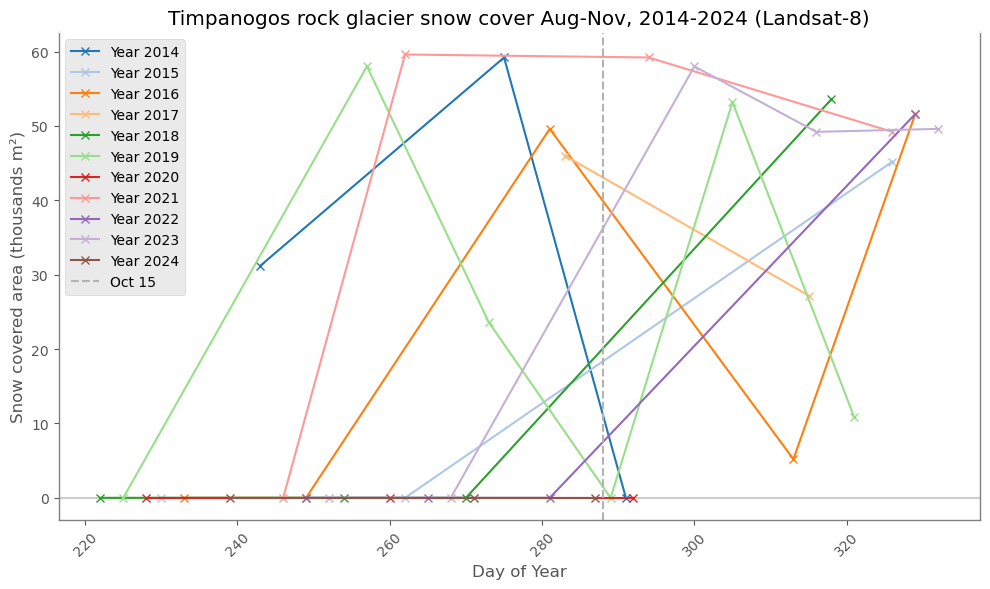

In [175]:
# plot 1
# all years 
# Plotting the area (in km²) over time with color by year
plt.style.use('ggplot')
cmap=plt.get_cmap('tab20')
# plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10, 6))
ax = plt.axes()
ax.set_facecolor('white')
ax.spines['bottom'].set_color('0.5')
ax.spines['right'].set_color('0.5'); ax.spines['left'].set_color('0.5')
plt.axhline(y=0, color='0.8', linestyle='-')

# Get unique years and plot each year with a different color
unique_years = df_rg['date'].dt.year.unique()
for i, year in enumerate(unique_years):
    year_data = df_rg[df_rg['date'].dt.year == year]
    plt.plot(year_data['day_of_year'], year_data['area_m2']/1000, 
             label=f'Year {year}', marker='x', color=cmap(i))
    
plt.axvline(x=288, color='0.7', linestyle='--', label='Oct 15')
plt.title('Timpanogos rock glacier snow cover Aug-Nov, 2014-2024 (Landsat-8)')
plt.xlabel('Day of Year')
plt.ylabel('Snow covered area (thousands m²)')
# plt.grid(True)
plt.xticks(rotation=45)
plt.legend(title=None, loc="upper left")
plt.tight_layout()

# Show the plot
plt.show()
# plt.savefig("figs/snowcover-sentinel2-end-season.png")

In [148]:
# look at individual years
df_rg[df_rg['date'].dt.year == 2021]

date  day_of_year  pixel_count  snow_perc  area_m2  area_km2  \
27 2021-09-03          246            0   0.000000        0    0.0000   
28 2021-09-19          262          149   1.000000    59600    0.0596   
29 2021-10-21          294          148   0.993289    59200    0.0592   
30 2021-11-22          326          123   0.825503    49200    0.0492   

    cloud_perc  
27   40.146023  
28  100.000000  
29    3.585613  
30   17.418369

In [160]:
# check imagery for certain dates (if necessary
start_date_0 = '2021-10-01' # Define the date range
end_date_0 = '2021-10-31' 

# Filter by date, cloud, months, and region
ls_new = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterDate(start_date_0, end_date_0).filterBounds(rg) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
    .filter(ee.Filter.calendarRange(9, 10, 'month'))
print('Number of scenes', ls_new.size().getInfo())
if(ls_new.size().getInfo() >1):
    break
Map = geemap.Map()
# ndsi_params = {'min': -1, 'max': 1, 'bands':'ndsi','palette': ['000FFF', '00FFFF']}
vis_params = {'min': 200, 'max': 60000, 'bands': ['B4', 'B3', 'B2']}
Map.centerObject(rg, 14)
Map.addLayer(ls_new.first(), vis_params, 'RGB')
# Map.addLayer(s2_ndsi.first().updateMask(s2_ndsi.first().gte(0.2)), ndsi_params, 'NDSI > 0.4')
Map

Number of scenes 0


SyntaxError: 'break' outside loop (3531184007.py, line 12)

In [173]:
def closest_to_oct15(group):
    oct15 = pd.Timestamp(f'{group["year"].iloc[0]}-10-15')  # October 15th of the year
    
    # Find the closest date before or on October 15
    before_oct15 = group[group['date'] <= oct15]
    after_oct15 = group[group['date'] >= oct15]
    
    # If there is no date before or on October 15, default to the closest date after
    if before_oct15.empty:
        closest = after_oct15.iloc[0]
    # If there is no date after or on October 15, default to the closest date before
    elif after_oct15.empty:
        closest = before_oct15.iloc[-1]
    else:
        # Otherwise, choose the one with the minimum area_km2
        before_oct15 = before_oct15.iloc[-1]
        after_oct15 = after_oct15.iloc[0]
        closest = before_oct15 if before_oct15['area_m2'] <= after_oct15['area_m2'] else after_oct15

    return closest

# Apply the function to the grouped data
df_oct15 = df_rg.groupby('year').apply(closest_to_oct15)[['date', 'area_m2']]
df_oct15

date  area_m2
year                    
2014 2014-10-18        0
2015 2015-09-19        0
2016 2016-11-08     5200
2017 2017-11-11    27200
2018 2018-09-27        0
2019 2019-10-16        0
2020 2020-09-16        0
2021 2021-10-21    59200
2022 2022-10-08        0
2023 2023-09-25        0
2024 2024-10-13        0

In [ ]:
# REDO late Oct

# Create a year column for easier grouping
df['year'] = df['date'].dt.year

# Filter the data for each year to keep only the rows before Oct 31
df_filtered = df[df['date'].dt.month < 10]  # This keeps only months before October

# For each year, find the row with the latest date and the lowest area_m2
result = df_filtered.groupby('year').apply(
    lambda group: group.loc[group.loc[group['date'] <= '10-31'].idxmax()['area_m2'], :]
).reset_index(drop=True)

In [174]:
# plot 3 
# df for min snow cover date
# df for min snow cover closest before/after Oct 15th

# Add a 'year' column to extract the year from the 'date'
df_rg['year'] = df_rg['date'].dt.year

# subset for minimum area_km2 per year
df_smin = df_rg.loc[df_rg.groupby('year')['area_m2'].idxmin()][['year', 'date', 'area_m2']]
# df_smin.rename(columns={'min_area': 'area_km2'}, inplace=True)

# subset for Minimum area_km2 for the closest date to October 15 of each year
df_oct15 = df_rg.groupby('year').apply(closest_to_oct15)[['date', 'area_m2']]

# combine and show restuls
# Merge the two DataFrames on the 'year' column using an outer join to keep all dates
dfsca = pd.merge(df_smin, df_oct15, on='year', how='outer', suffixes=('_min', '_closest'))
dfsca.head(6)
# dfsca_yr = pd.merge(df_smin, df_oct15, left_index=True, right_index=True)
# dfsca_yr.head(5)

year   date_min  area_m2_min date_closest  area_m2_closest
0  2014 2014-10-18            0   2014-10-18                0
1  2015 2015-08-18            0   2015-09-19                0
2  2016 2016-08-20            0   2016-11-08             5200
3  2017 2017-11-11        27200   2017-11-11            27200
4  2018 2018-08-10            0   2018-09-27                0
5  2019 2019-08-13            0   2019-10-16                0

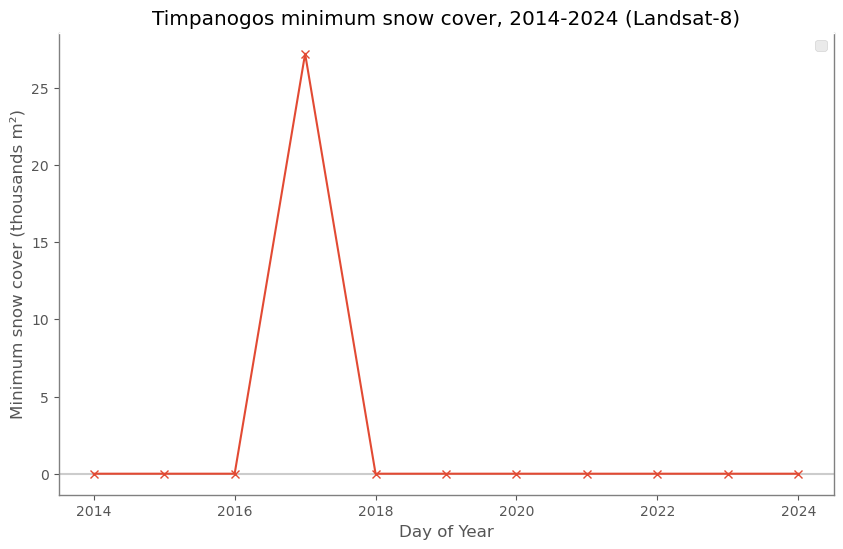

In [176]:
# plot 2 
# show minimum value from each year
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
ax = plt.axes()
ax.set_facecolor('white')
ax.spines['bottom'].set_color('0.5')
ax.spines['right'].set_color('0.5'); ax.spines['left'].set_color('0.5')
plt.axhline(y=0, color='0.8', linestyle='-')

plt.plot(dfsca['year'], dfsca['area_m2_min']/1000, marker='x')
# dfsca.plot(x='year', y='area_km2_min', kind='line', marker='x', color='k')

plt.title('Timpanogos minimum snow cover, 2014-2024 (Landsat-8)')
plt.xlabel('Day of Year')
plt.ylabel('Minimum snow cover (thousands m²)')
plt.legend("")
plt.grid(True)
plt.show()
# plt.savefig("figs/snowcover-sentinel2-annual.png")

In [74]:
# plot 3
# plt.style.use('ggplot')
# plt.figure(figsize=(10, 6))

# dfsca.plot(x='year', y='area_km2_closest', kind='line', marker='x', color='k')
# plt.title('Timpanogos glacier minimum snow cover area, 2019-2024 (Sentinel-2)')
# plt.xlabel('Day of Year')
# plt.ylabel('Minimum snow cover (km²)')
# plt.legend("")
# plt.grid(True)
# plt.show()

In [167]:
# Map 1
Map = geemap.Map()
ndsi_params = {'min': -1, 'max': 1, 'bands':'ndsi','palette': ['000FFF', '00FFFF']}
vis_params = {'min': 0, 'max': 0.35, 'bands': ['SR_B4', 'SR_B3', 'SR_B2']}
Map.centerObject(rg, 14)
Map.addLayer(ls8.first().multiply(0.0000275).add(-0.2), vis_params, 'RGB')
Map.addLayer(ls8_clip.first(), vis_params, 'RGB clip')
Map.addLayer(ls8_ndsi.first().updateMask(ls8_ndsi.first().gte(0.4)), ndsi_params, 'NDSI > 0.4')
Map

Map(center=[40.389565168100816, -111.64058143725468], controls=(WidgetControl(options=['position', 'transparen…

In [177]:
dfsca.head(6)

year   date_min  area_m2_min date_closest  area_m2_closest
0  2014 2014-10-18            0   2014-10-18                0
1  2015 2015-08-18            0   2015-09-19                0
2  2016 2016-08-20            0   2016-11-08             5200
3  2017 2017-11-11        27200   2017-11-11            27200
4  2018 2018-08-10            0   2018-09-27                0
5  2019 2019-08-13            0   2019-10-16                0

In [215]:

pixel_count = ls8_ndsi.first().reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=rg,
    scale=30
).getInfo()

img_ndsi = ls8_ndsi.first()
img_ndsi = img_ndsi.updateMask(img_ndsi.gte(0.4))

pixel_count2 = img_ndsi.reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=rg,
    scale=30
).getInfo()

# ndsi_minmax = img_ndsi.reduceRegion(
#     reducer=ee.Reducer.minMax(),
#     geometry=rg,
#     scale=30
# ).getInfo()
# print(ndsi_minmax['ndsi'])

tot_pix = pixel_count['ndsi']
s_pix = pixel_count2['ndsi']

# Print the result
print(f"Total number of pixels: {tot_pix}")
print(f"Masked pixels: {s_pix}")
print(f"Max pixel count in dataset: {df_rg['pixel_count'].max()}")
print(f"SCA is {s_pix/tot_pix}%")


Total number of pixels: 139
Masked pixels: 0
Max pixel count in dataset: 149
SCA is 0.0%


In [234]:
p1 = ls8_ndsi.first().reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=rg,
    scale=30
).getInfo()

p2 = ls8_thresh.first().reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=rg,
    scale=30
).getInfo()

print(f"image1 - total {p1['ndsi']} thresh {p2['ndsi']}")

p1 = ee.Image(ls8_ndsi.toList(5).get(4)).reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=rg,
    scale=30
).getInfo()

p2 = ee.Image(ls8_thresh.toList(5).get(4)).reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=rg,
    scale=30
).getInfo()

print(f"other - total {p1['ndsi']} thresh {p2['ndsi']}")

image1 - total 139 thresh 0
other - total 149 thresh 1


In [209]:
img_ndsi = ls8_ndsi.first()
img_ndsi = img_ndsi.updateMask(img_ndsi.gte(0.4))
img_ndsi.reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=rg,
    scale=30
).getInfo()

{'QA_PIXEL': 149,
 'QA_RADSAT': 0,
 'SR_B1': 105,
 'SR_B2': 107,
 'SR_B3': 106,
 'SR_B4': 107,
 'SR_B5': 111,
 'SR_B6': 88,
 'SR_B7': 76,
 'SR_QA_AEROSOL': 0,
 'ST_ATRAN': 0,
 'ST_B10': 149,
 'ST_CDIST': 0,
 'ST_DRAD': 0,
 'ST_EMIS': 0,
 'ST_EMSD': 0,
 'ST_QA': 0,
 'ST_TRAD': 0,
 'ST_URAD': 0,
 'ndsi': 0}

In [218]:
# Map ALL END OF YEAR SCENES

# Create an example ImageCollection (replace this with your own ImageCollection)
collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterBounds(rg) \
    .filter(ee.Filter.lt('CLOUD_COVER', 10)) \
    .filter(ee.Filter.calendarRange(8, 11, 'month'))  

# List of dates in 'YYYY-MM-DD' format
dates_list = dfsca['date_min'] #[0:5]

# Convert the list to a format that Earth Engine can use
dates = [ee.Date(date) for date in dates_list]

# Filter the collection by each date in the list
filtered_collection = ee.ImageCollection([collection.filterDate(date, date.advance(1, 'day')).first() for date in dates])

# Initialize geemap Map
Map = geemap.Map()
Map.centerObject(rg, 14)
vis_params = {'min': 0, 'max': 0.35, 'bands': ['SR_B4', 'SR_B3', 'SR_B2']}
rg_poly_params = {'color': '000000', 'pointSize': 3, 'width': 2, 'lineType': 'solid', 'fillColor': '00000000'}
ndsi_params = {'min': -1, 'max': 1, 'bands':'ndsi','palette': ['000FFF', '00FFFF']}

# Function to format timestamp as a human-readable string
def format_timestamp(image):
    timestamp = image.get('system:time_start')
    formatted_timestamp = ee.Date(timestamp).format('YYYY-MM-dd')  # Change the format as needed
    return image.set('formatted_timestamp', formatted_timestamp)

# Apply the function to each image in the collection to add a formatted timestamp
formatted_collection = filtered_collection.map(format_timestamp)

# Add the images to the map
def add_to_map(image):
    # Get the formatted timestamp from the image
    formatted_timestamp = image.get('formatted_timestamp')
    # Add the image to the map with the formatted timestamp as the layer name
    Map.addLayer(image.multiply(0.0000275).add(-0.2), vis_params, f"RGB {formatted_timestamp.getInfo()}")
    # add ndsi? 
    img_ndsi = ls8_ndsi_clip(image)
    img_ndsi = img_ndsi.updateMask(img_ndsi.gte(0.4))
    Map.addLayer(img_ndsi, ndsi_params, f"ndsi {formatted_timestamp.getInfo()}")
    #
    pixel_count2 = img_ndsi.reduceRegion(reducer=ee.Reducer.count(),geometry=rg,scale=30).getInfo()
    s_pix = pixel_count2['ndsi']
    print(f"Date: {formatted_timestamp.getInfo()} \n SCA: {round(s_pix/149 * 100, 2)}% or {s_pix*30*30}m^2")
    
# Loop through the images and add them to the map
image_list = formatted_collection.toList(formatted_collection.size())
for i in range(image_list.size().getInfo()):
    image = ee.Image(image_list.get(i))
    add_to_map(image)

Map.addLayer(rg.style(**rg_poly_params), {}, "Rock glacier outline")

Map


Date: 2014-10-18 
 SCA: 10.74% or 14400m^2
Date: 2015-08-18 
 SCA: 0.67% or 900m^2
Date: 2016-08-20 
 SCA: 1.34% or 1800m^2
Date: 2017-11-11 
 SCA: 93.29% or 125100m^2
Date: 2018-08-10 
 SCA: 2.01% or 2700m^2
Date: 2019-08-13 
 SCA: 64.43% or 86400m^2
Date: 2020-08-15 
 SCA: 24.83% or 33300m^2
Date: 2021-09-03 
 SCA: 0.0% or 0m^2
Date: 2022-09-06 
 SCA: 0.67% or 900m^2
Date: 2023-09-09 
 SCA: 41.61% or 55800m^2
Date: 2024-08-26 
 SCA: 26.85% or 36000m^2


Map(center=[40.389565168100816, -111.64058143725468], controls=(WidgetControl(options=['position', 'transparen…

In [170]:
# plot any date in LIAR

Map = geemap.Map()

scene_number = 8
max_scene = 10 # 10

image_id = ee.Image(ls8.toList(10).get(scene_number)).get('system:index').getInfo()
date_part = image_id[-8:]
date_obj = datetime.strptime(date_part, '%Y%m%d')
formatted_date = date_obj.strftime('%m-%d-%Y')
print("Scene aquisition " + formatted_date)

image = ee.Image(ls8_clip.toList(max_scene).get(scene_number))
# img_ndsi = ee.Image(s2_ndsi.toList(max_scene).get(scene_number)).updateMask(s2_ndsi.first().gte(0.2))
img_ndsi = ee.Image(ls8_ndsi.toList(max_scene).get(scene_number))
img_ndsi_mask = img_ndsi.updateMask(img_ndsi.gte(0.4))

Map.centerObject(rg, 15)
Map.addLayer(image, \
             {'min': 0, 'max': 0.35, 'bands': ['SR_B4', 'SR_B3', 'SR_B2']}, formatted_date)
Map.addLayer(img_ndsi_mask, \
             {'min': -1, 'max': 1, 'bands':'ndsi','palette': ['000FFF', '00FFFF']}, 'NDSI > 0.2')
Map

Scene aquisition 09-05-2016


Map(center=[40.389565168100816, -111.64058143725468], controls=(WidgetControl(options=['position', 'transparen…

In [85]:
# Map 2
# with outline
Map = geemap.Map()
Map.centerObject(rg, 15)
poly_params = {'color': '000000', 'pointSize': 3,'width': 2,'lineType': 'solid','fillColor': '00000000'}
vis_params = {'min': 0, 'max': 0.35, 'bands': ['B4', 'B3', 'B2']}
ndsi_params = {'min': -1, 'max': 1, 'bands':'ndsi','palette': ['000FFF', '00FFFF']}
Map.centerObject(rg, 15)
Map.addLayer(s2_clip.first(), vis_params, 'RGB')
Map.addLayer(s2_ndsi.first().updateMask(s2_ndsi.first().gte(0.2)), ndsi_params, 'NDSI > 0.2')
Map.addLayer(rg.style(**poly_params), {}, "Timp rock glacier")
Map

Map(center=[40.389565168100816, -111.64058143725468], controls=(WidgetControl(options=['position', 'transparen…

In [89]:
# Map 3
# different day plot
Map = geemap.Map()

scene_number = 4

image_id = ee.Image(s2_clip.toList(10).get(scene_number)).get('system:index').getInfo()
date_part = image_id.split('T')[0]
date_obj = datetime.strptime(date_part, '%Y%m%d')
formatted_date = date_obj.strftime('%m-%d-%Y')

vis_params = {'min': 0, 'max': 0.35, 'bands': ['B4', 'B3', 'B2']}
Map.centerObject(rg, 15)
Map.addLayer(ee.Image(s2_clip.toList(10).get(scene_number)), vis_params, formatted_date)

Map

Map(center=[40.389565168100816, -111.64058143725468], controls=(WidgetControl(options=['position', 'transparen…

In [107]:
# Map 3
# reducer - showing the coverage minimum of each year

def count_unmasked_years(image):
    # Assume the mask is applied, with unmasked pixels having value 1, and masked pixels having value 0.
    # You could create a binary mask if needed for counting:
    unmasked_pixels = image.mask().reduceRegion(
        reducer=ee.Reducer.count(),  # Count the number of unmasked pixels
        geometry=rg,
        scale=30,  # Adjust scale to match the resolution of your image
        maxPixels=1e8
    )
    return unmasked_pixels

def create_unmasked_years_count_image(collection, roi):
    # Create a binary mask to count pixels that are unmasked
    def process_image(image):
        # Mask out the unmasked pixels with a value of 1 and masked pixels with a value of 0
        return image.updateMask(image.mask()).multiply(1)

    # Apply processing to the entire collection
    binary_images = collection.map(process_image)
    
    # Reduce the collection over time (count the unmasked years for each pixel)
    years_unmasked = binary_images.sum()
    
    return years_unmasked

# Example usage:
s2_thresh = s2_ndsi.filterBounds(rg)  # Make sure the collection is within the region of interest

# Now create the unmasked years count image
unmasked_years_image = create_unmasked_years_count_image(s2_thresh, rg).select([0])


In [108]:
unmasked_years_image

In [109]:
# Display the resulting image
Map = geemap.Map()
Map.centerObject(rg, 15)
Map.addLayer(unmasked_years_image, \
             {'min': 0, 'max': 10, 'palette': ['blue', 'green', 'yellow', 'red']}, \
             "Unmasked Years Count")
Map

Map(center=[40.389565168100816, -111.64058143725468], controls=(WidgetControl(options=['position', 'transparen…

In [110]:

# Function to process and mask the image
def process_image(image):
    # Mask out the unmasked pixels (1 for unmasked, 0 for masked)
    return image.updateMask(image.mask()).multiply(1)

# Create an image that counts unmasked years per pixel
def create_unmasked_years_count_image(collection, roi):
    # Apply processing to the entire collection (binary mask with 1 for unmasked)
    binary_images = collection.map(process_image)
    
    # Reduce the collection over time by summing the binary values for each pixel
    years_unmasked = binary_images.sum()
    
    # Clip the result to the ROI for cleaner visualization
    years_unmasked_clipped = years_unmasked.clip(roi)
    
    return years_unmasked_clipped

# Example usage:
# Assuming s2_thresh is a valid image collection filtered for your region of interest (rg)
s2_ndsi2 = s2_ndsi.filterBounds(rg)  # Filter the collection for the region of interest

# Create the image that counts unmasked years per pixel
unmasked_years_image = create_unmasked_years_count_image(s2_ndsi2, rg)

# Inspect the minimum and maximum values to set appropriate visualization range
min_value = unmasked_years_image.reduceRegion(
    reducer=ee.Reducer.min(),
    geometry=rg,
    scale=30,  # Adjust as necessary
    maxPixels=1e8
).getInfo()

max_value = unmasked_years_image.reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=rg,
    scale=30,  # Adjust as necessary
    maxPixels=1e8
).getInfo()

# Print out the minimum and maximum values to adjust the color scale
print(f"Min value: {min_value}")
print(f"Max value: {max_value}")

# If there's only one band, select the band explicitly (if necessary)
unmasked_years_image_band = unmasked_years_image.select([0])  # Select the first band if it's single-band

# Display the resulting image on the map
Map = geemap.Map()
Map.centerObject(rg, 10)  # Center the map on the region of interest

# Update color palette based on the min/max value
Map.addLayer(unmasked_years_image_band, {
    'min': 0, 
    'max': 10,  # Update this based on the min and max values
    'palette': ['blue', 'green', 'yellow', 'red']
}, "Unmasked Years Count")

# Show the map
# Map



Min value: {'AOT': 0.7018000000000001, 'B1': 11.5582, 'B11': 5.329999999999998, 'B12': 4.994599999999999, 'B2': 10.741599999999996, 'B3': 11.246899999999998, 'B4': 11.074499999999999, 'B5': 11.533500000000002, 'B6': 11.446499999999997, 'B7': 10.928900000000002, 'B8': 10.723899999999997, 'B8A': 10.5745, 'B9': 16.8237, 'MSK_CLASSI_CIRRUS': 0, 'MSK_CLASSI_OPAQUE': 0, 'MSK_CLASSI_SNOW_ICE': 0.0001, 'MSK_CLDPRB': 0.005399999999999999, 'MSK_SNWPRB': 0.0529, 'QA10': 0, 'QA20': 0, 'QA60': 0.6144000000000001, 'SCL': 0.034599999999999985, 'TCI_B': 0.7185000000000001, 'TCI_G': 0.7548999999999998, 'TCI_R': 0.7421999999999997, 'WVP': 2.2696999999999994, 'ndsi': -10.178221893940844}
Max value: {'AOT': 0.8437, 'B1': 24.251900000000003, 'B11': 17.7528, 'B12': 16.825299999999995, 'B2': 31.732699999999998, 'B3': 34.03779999999999, 'B4': 35.203, 'B5': 37.0302, 'B6': 36.020999999999994, 'B7': 34.6506, 'B8': 33.9713, 'B8A': 33.0717, 'B9': 29.418900000000004, 'MSK_CLASSI_CIRRUS': 0, 'MSK_CLASSI_OPAQUE': 0, 

In [106]:

# Export pixel count information to a dataframe
def get_pixel_counts(image):
    # Get the pixel values and count occurrences
    pixel_values = image.reduceRegion(
        reducer=ee.Reducer.frequencyHistogram(),
        geometry=rg,
        scale=30,  # Adjust this scale as needed (use 10m for Sentinel-2)
        maxPixels=1e8
    )
    
    return pixel_values

# Get the pixel counts for the unmasked years image
pixel_counts = get_pixel_counts(unmasked_years_image_band)

# Convert to a dictionary and then to a pandas dataframe
pixel_counts_dict = pixel_counts.getInfo()

# Make sure we're only dealing with the actual pixel values, not band names like 'B1'
pixel_values_dict = pixel_counts_dict.get('0', {})  # Get the frequency histogram of the band

# Convert the dictionary to a DataFrame
counts_df = pd.DataFrame(list(pixel_values_dict.items()), columns=["Pixel Value", "Count"])

# Display the dataframe with the counts of each distinct value
print(counts_df)

Empty DataFrame
Columns: [Pixel Value, Count]
Index: []


## Extras

In [ ]:
# FAILED CLOUD MASK
# from: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_HARMONIZED#description

# def mask_s2_clouds(image):
#   """Masks clouds in a Sentinel-2 image using the QA band.
#   Args:
#       image (ee.Image): A Sentinel-2 image.
#   Returns:
#       ee.Image: A cloud-masked Sentinel-2 image.
#   """
#   qa = image.select('QA60')

#   # Bits 10 and 11 are clouds and cirrus, respectively.
#   cloud_bit_mask = 1 << 10
#   cirrus_bit_mask = 1 << 11

#   # Both flags should be set to zero, indicating clear conditions.
#   mask = (
#       qa.bitwiseAnd(cloud_bit_mask)
#       .eq(0)
#       .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
#   )

#   return image.updateMask(mask).divide(10000)

# s2_collection = s2_filtered.map(mask_s2_clouds)